In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import numpy as np
import scipy.optimize as opt
from scipy import interpolate
import scipy.io as sio
import scipy.special as spf
import yaml

## import diffrantion integral solver from Optics folder
work_dir = os.getcwd()
date_dir = os.path.split(work_dir)[0]
optics_folder = os.path.join(date_dir, 'Optics')
sys.path.append(optics_folder)
sys.path.append(date_dir)
import diffraction_int as diffi
import fibonacci as fib


## Import field functions
# field_module_folder = os.path.join(date_dir, 'field_functions')             
# sys.path.append(field_module_folder)
# import far_fields as fi

## Read parameter file to obtain fields
stream = open('../curly_param.yaml','r')
parameters = yaml.load(stream)


## plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rcParams['text.usetex'] = True

## colorbar stuff 
from mpl_toolkits import axes_grid1

# import eqm_slns as osc

## analytic image functions
# import analytic_intensity_functions_xyz as imf

## dipole moments as functions of separation, not pulled from param file
# import p_of_d_genOr as pod

# pretty fitting
# import lmfit as lf

import anal_foc_diff_fields as afi

import coupled_dipoles as cp 

## Import physical constants
full_path_to_constant_yaml = os.path.join(date_dir,'physical_constants.yaml')
opened_constant_file = open(full_path_to_constant_yaml,'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## System background
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.

a = parameters['plasmon']['radius']
#######################################################################
## simulated image 
sensor_size = 2000*nm
# height = 2*mm  # also defines objective lens focal length 
height = .2
resolution = 100  # image grid resolution

norm_style = 'per fig'  # 'per fig' or 'across figs'

show_or_save = 'show'
# show_or_save = raw_input('( show / save ) figures? ')

file_extension = 'pdf'  # 'pdf' for mest quality

## plot parameters
plot_scale = 1/nm

#######################################################################
## Optics stuff.  

## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = 1
numerical_aperture = 1
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = 1000

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = height

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = 1.86 ## rod long mode max at 1.8578957289256757 eV
omega_drive = drive_hbar_omega/hbar  # driving frequency

reading parameters from ../curly_param.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


In [2]:
fit_result_params = (
    ## eps_inf, hbar*omega_p, hbar*gamma_nr, eps_b (not used as fit param), a_x, a_yz
    15.100176  , 10.15232758/hbar,  0.10316881/hbar, 1.0, 67.24906658*nm, 19.20816015*nm
    )
alpha0_diag_dyad = cp.sparse_polarizability_tensor(
    mass=cp.fluorophore_mass(
        ext_coef=parameters['fluorophore']['extinction_coeff'], 
        gamma=parameters['fluorophore']['mass_gamma']/hbar
        ), 
    w_res=drive_hbar_omega/hbar, 
    w=drive_hbar_omega/hbar, 
    gamma_nr=parameters['fluorophore']['test_gamma']/hbar,
    a=0, 
    eps_inf=1, 
    ebs_b=1
    )
alpha1_diag_dyad = cp.sparse_ret_prolate_spheroid_polarizability_Drude(
        omega_drive, *fit_result_params)
# alpha1_diag_dyad_no_trans = alpha1_diag_dyad
# alpha1_diag_dyad_no_trans[1,1] = 0
# alpha1_diag_dyad_no_trans[2,2] = 0


In [3]:
def mb_p_fields(dipole_mag_array, dipole_coordinate_array):
    ''' As of 081418,fixing: currently only treats dipole at origin.'''    
    p = dipole_mag_array
#     print('Inside mb_p_fields, p= ',p)
    bfx = dipole_coordinate_array

    v_rel_obs_x_pts = (eye[1].ravel()[:,None] - bfx.T[0]).T
    v_rel_obs_y_pts = (eye[2].ravel()[:,None] - bfx.T[1]).T
    
    px_fields = np.asarray(afi.E_field(0, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
    py_fields = np.asarray(afi.E_field(np.pi/2, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
    pz_fields = np.zeros(py_fields.shape)
#     print('px_fields.shape=',px_fields.shape)
#     print('p.shape=',p.shape)
    ## returns [Ex, Ey, Ez] for dipoles oriented along cart units
    
    Ex = p[:,0,None]*px_fields[0] + p[:,1,None]*py_fields[0] + p[:,2,None]*pz_fields[0]
    Ey = p[:,0,None]*px_fields[1] + p[:,1,None]*py_fields[1] + p[:,2,None]*pz_fields[1]
    Ez = p[:,0,None]*px_fields[2] + p[:,1,None]*py_fields[2] + p[:,2,None]*pz_fields[2]

    return np.array([Ex,Ey,Ez])

def dipole_fields(locations, mol_angle=0, plas_angle=np.pi/2):
    d = locations*nm
    p0, p1 = cp.dipole_mags_gened(mol_angle, plas_angle, d_col=d, E_d_angle=None,
                                  alpha0_diag=alpha0_diag_dyad,
                                  alpha1_diag=alpha1_diag_dyad)
    mol_E = mb_p_fields(dipole_mag_array=p0, dipole_coordinate_array=d) 
    plas_E = mb_p_fields(dipole_mag_array=p1, dipole_coordinate_array=np.zeros(d.shape))

    # p0_unc, = cp.uncoupled_p0(mol_angle=0, d_col=d[0,None], E_d_angle=None)
    p0_unc, = cp.uncoupled_p0(mol_angle, E_d_angle=None, drive_hbar_w=drive_hbar_omega)
#     print('p0.shape = ',p0.shape)
#     print('p1.shape = ',p1.shape)
#     print('p0_unc.shape = ',p0_unc.shape)
#     p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=np.zeros(d[0][None,:].shape))
    if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
        p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc, dipole_coordinate_array=d)
    elif (type(mol_angle) == int or
          type(mol_angle) == float or
          (type(mol_angle) == np.ndarray and mol_angle.shape[0]==1)
          ):
        p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=d)
    
    return [mol_E, plas_E, p0_unc_E, p0, p1]

def powers_and_angels(E):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_Ix = np.abs(E[0])**2. / drive_I
    normed_Iy = np.abs(E[1])**2. / drive_I

    Px_per_drive_I = np.sum(normed_Ix,axis=-1) / sensor_size**2.
    Py_per_drive_I = np.sum(normed_Iy,axis=-1) / sensor_size**2.
    

    angles = np.arctan(Py_per_drive_I**0.5/Px_per_drive_I**0.5)
    return [angles, Px_per_drive_I, Py_per_drive_I]

def powers_and_angels_no_interf(E1,E2):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_Ix = (np.abs(E1[0])**2. + np.abs(E2[0])**2.) / drive_I
    normed_Iy = (np.abs(E1[1])**2. + np.abs(E2[1])**2.) / drive_I

    Px_per_drive_I = np.sum(normed_Ix,axis=-1) / sensor_size**2.
    Py_per_drive_I = np.sum(normed_Iy,axis=-1) / sensor_size**2.
    

    angles = np.arctan(Py_per_drive_I**0.5/Px_per_drive_I**0.5)
    return [angles, Px_per_drive_I, Py_per_drive_I]

In [4]:
def twoD_Gaussian(
    X, ## tuple of meshed (x,y) values
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset
    ):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((X[0]-xo)**2) + 2*b*(X[0]-xo)*(X[1]-yo) 
        + c*((X[1]-yo)**2)))
    return g.ravel()

def misloc_data_minus_model(fit_params, *normed_raveled_image_data):
    ''' fit gaussian to data '''
    gaus = twoD_Gaussian(
        (eye[1]/nm, eye[2]/nm),
        *fit_params ## ( A, xo, yo, sigma_x, sigma_y, theta, offset)
        )
    
    return gaus - normed_raveled_image_data

def calculate_max_xy(images):
    ## calculate index of maximum in each image. 
    apparent_centroids_idx = images.argmax(axis=-1)
    ## define locations for each maximum in physical coordinate system

    x_cen = (eye[1]/nm).ravel()[apparent_centroids_idx]
    y_cen = (eye[2]/nm).ravel()[apparent_centroids_idx]
    
    ## these are locations of molecules, not the same thing I need pizel locations in eye. 
#     x_mesh, y_mesh = np.meshgrid(x,y)
#     x_cen = x_mesh.ravel()[apparent_centroids_idx]
#     y_cen = y_mesh.ravel()[apparent_centroids_idx]

    return [x_cen,y_cen]

def calculate_apparent_centroids(images):
    ## calculate index of maximum in each image. 
    num_of_images = images.shape[0]
    
    apparent_centroids_xy = np.zeros((num_of_images,2))
    
    max_positions = calculate_max_xy(images)
    
    for i in np.arange(num_of_images):
        x0 = max_positions[0][i]
        y0 = max_positions[1][i]        
        params0 = (1,x0,y0,100, 100, 0,0)
        args=tuple(images[i]/np.max(images[i]))
        fit_gaussian = opt.least_squares(misloc_data_minus_model, params0, args=args)
        resulting_fit_params = fit_gaussian['x']
        fit_result = twoD_Gaussian(
            (eye[1]/nm, eye[2]/nm), ## tuple of meshed (x,y) values
            *resulting_fit_params
            )
        centroid_xy = resulting_fit_params[1:3]
        apparent_centroids_xy[i] = centroid_xy
    ## define locations for each maximum in physical coordinate system

    return apparent_centroids_xy.T  ## returns [x_cen(s), y_cen(s)]

def image_from_E(E):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_I = np.sum(np.abs(E)**2.,axis=0) / drive_I

#     P_per_drive_I = normed_I,axis=-1) / sensor_size**2.

    return normed_I

def connectpoints(cen_x, cen_y, mol_x, mol_y, p, ax=None, zorder=1):
    x1, x2 = mol_x[p], cen_x[p]
    y1, y2 = mol_y[p], cen_y[p]
    if ax == None:
        plt.plot([x1,x2],[y1,y2],'k-', linewidth=.3, zorder=zorder)
    else: 
        ax.plot([x1,x2],[y1,y2],'k-', linewidth=.3, zorder=zorder)
        
def scatter_centroids_wLine(x_mol_loc, y_mol_loc, E, ax=None):

    trial_images = image_from_E(E)
    appar_cents = calculate_apparent_centroids(trial_images)

    x, y = appar_cents
    
    ## This part doesnt work right now
    el_a = 19
    el_c = 67
    quel_a = el_a + 10
    quel_c = el_c + 10
    pt_is_in_ellip = np.ones(x.shape, dtype=bool)
#     for i in np.arange(x.shape[0]):
#         if (x[i]**2./quel_a**2. +  y[i]**2./quel_c**2.) < 1:
#             pt_is_in_ellip[i] = False
    ####
    
    x_plot = x[pt_is_in_ellip]
    y_plot = y[pt_is_in_ellip]

    if ax == None:
        plt.figure(dpi=300)
        for i in np.arange(x_plot.shape[0]):
            connectpoints(x_plot, y_plot, x_mol_loc, y_mol_loc, i,zorder=2)
        
        plt.scatter(x_plot, y_plot, s=10, c='Red', zorder=3)
        plt.tight_layout()
        

    else:
        for i in np.arange(x_plot.shape[0]):
            connectpoints(x_plot, y_plot, x_mol_loc, y_mol_loc, i, ax,zorder=2)
        ax.scatter(x_plot, y_plot, s=10, c='Red', zorder=3)
        return ax
#     plt.xlim([-2000,2000])
#     plt.ylim([-2000,2000])

In [371]:
def quiver_plot(x_plot, y_plot, angles, plot_limits=[-25,550],
               title=r'Apparent pol. per mol. pos.', true_mol_angle=angles,
               nanorod_angle=0):

    el_a = 19
    el_c = 67
    quel_a = el_a + 10
    quel_c = el_c + 10
    pt_is_in_ellip = np.ones(x_plot.shape, dtype=bool)
#     for i in np.arange(x_plot.shape[0]):
#         if (x_plot[i]**2./quel_a**2. +  y_plot[i]**2./quel_c**2.) < 1:
#             pt_is_in_ellip[i] = False
    
    x_plot = x_plot[pt_is_in_ellip]
    y_plot = y_plot[pt_is_in_ellip]
    angles = angles[pt_is_in_ellip]
    
    fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(3.25,3), dpi=300, 
                                       gridspec_kw = {'width_ratios':[6, 0.5]}
                                      )

    cmap = mpl.cm.nipy_spectral
    
    ## Mark molecule locations
    scat_tr = ax0.scatter(x_plot, y_plot, s=3, 
                    color='black',
    #                    cmap='inferno',
    #                    clim = [0, np.pi/2], 
#                        width=0.005,
#                        scale=20,
            #            scale_units='width',
#                        pivot='mid',
    #                   linewidth=100.,
#                       headaxislength=0.0,
#                       headlength=0.0
                      )
    ## mark true orientation
    quiv_tr = ax0.quiver(x_plot, y_plot, np.cos(true_mol_angle),np.sin(true_mol_angle), 
                    color='black',
    #                    cmap='inferno',
    #                    clim = [0, np.pi/2], 
                       width=0.005,
                       scale=15,
            #            scale_units='width',
                       pivot='mid',
    #                   linewidth=100.,
                      headaxislength=0.0,
                      headlength=0.0
                      )
    
    ## Mark apparent orientation
    quiv_ap = ax0.quiver(x_plot, y_plot, 
                      np.cos(angles),
                      np.sin(angles), 
                      angles,
                      cmap=cmap,
                      clim = [0, np.pi/2], 
                      width=0.01,
                      scale=12,
            #            scale_units='width',
                      pivot='mid',
                      zorder=4,
                      headaxislength=2.5,
                      headlength=2.5,
                      headwidth=2.5
                      )

    ax0.axis('equal')
    ax0.set_xlim(plot_limits)
    ax0.set_ylim(plot_limits)
    ax0.set_title(title)
    ax0.set_xlabel('x [nm]')
    ax0.set_ylabel('y [nm]')

    norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

    cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label(r'observed angle $\phi$')
#     plas_dot = ax0.scatter(0,0,color='k',s=30)
    cb1.set_ticks([0, np.pi/8, np.pi/4, np.pi/8 * 3, np.pi/2])
    cb1.set_ticklabels([r'$0$', r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])

#     fig.tight_layout()
    
    quiver_axis_handle = ax0
    
    
    if nanorod_angle == np.pi/2:
        #### Draw rod
        circle = mpl.patches.Circle((0, 24), 20, facecolor='Gold',
                    edgecolor='Black', linewidth=0)
        bot_circle = mpl.patches.Circle((0, -24), 20, facecolor='Gold',
                    edgecolor='Black', linewidth=0)
        rect = mpl.patches.Rectangle((-20,-24), 40, 48, angle=0.0, facecolor='Gold',
                    edgecolor='Black', linewidth=0)

        ax0.add_patch(circle)
        ax0.add_patch(rect)
        ax0.add_patch(bot_circle)
    
    ## model ellipsoid
    ellip = mpl.patches.Ellipse((0,0), 2*el_c, 2*el_a, angle=nanorod_angle*180/np.pi, fill=False, edgecolor='Black',linestyle='--')
    ax0.add_patch(ellip)
    return [quiver_axis_handle]

In [372]:
def calculate_mislocalization_magnitude(x_cen, y_cen, x_mol, y_mol):
    misloc = ( (x_cen-x_mol)**2. + (y_cen-y_mol)**2. )**(0.5)
    return misloc

 

In [376]:
class MolCoupNanoRodExp:
    ''' Collect focused+diffracted far-field information from molecules nearby a nanorod '''
    
    ## set up inverse mapping from observed -> true angle for signle molecule in the plane. 
    saved_mapping = np.loadtxt('obs_pol_vs_true_angle.txt')
    true_ord_angles, obs_ord_angles =  saved_mapping.T
    #from scipy import interpolate
    f = interpolate.interp1d(true_ord_angles,obs_ord_angles)
    f_inv = interpolate.interp1d(
        obs_ord_angles[:251],
        true_ord_angles[:251],
        bounds_error=False,
        fill_value=(0,np.pi/2)
        )

        
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2, save_fields=False):
        self.mol_locations = locations
        self.mol_angles = mol_angle
        self.rod_angle = plas_angle
        
        #### Filtering out molecules in region of fluorescence quenching 
        self.el_a = 19 ## ranorod degenerate radius
        self.el_c = 67
        self.quel_a = self.el_a + 10 ## define quenching region
        self.quel_c = self.el_c + 10
        self.input_x_mol = locations[:,0]
        self.input_y_mol = locations[:,1]
        
        self.pt_is_in_ellip = self.mol_too_close()
        ## select molecules outside region,
        self.mol_locations = locations[self.pt_is_in_ellip]
        ## select molecule angles if listed per molecule, 
        if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
            self.mol_angles = mol_angle[self.pt_is_in_ellip]
        else: self.mol_angles = mol_angle
        
        (self.mol_E, 
         self.plas_E, 
         self.p0_unc_E, 
         self.p0, 
         self.p1) = dipole_fields(self.mol_locations, self.mol_angles, self.rod_angle)
        
        self.trial_images = image_from_E(self.mol_E + self.plas_E )

        self.appar_cents = calculate_apparent_centroids(self.trial_images)
        self.x_cen, self.y_cen = self.appar_cents
        
        ## Calculate polarization with beam splitter
        self.angles, self.Px_per_drive_I, self.Py_per_drive_I = powers_and_angels(
            self.mol_E + self.plas_E
            )
        self.mispol_angle= MolCoupNanoRodExp.f_inv(self.angles)

        self.default_plot_limits = [
            np.min(self.mol_locations)-((np.max(self.mol_locations)-np.min(self.mol_locations))*.1),
            np.max(self.mol_locations)+((np.max(self.mol_locations)-np.min(self.mol_locations))*.1)]
        
        if save_fields == False:
            del self.mol_E
            del self.plas

    def in_quench_zone(self):
        pt_is_in_ellip = np.ones(self.input_x_mol.shape, dtype=bool) ## initialize index array
        for i in np.arange(locations[:,0].shape[0]):  
            ## currently works only if nanorod is vertically oriented
            if (self.input_x_mol[i]**2./self.quel_a**2. +  self.input_y_mol[i]**2./self.quel_c**2.) < 1:
                pt_is_in_ellip[i] = False
        return pt_is_in_ellip
    
    def mol_too_close(self):
        rotated_x = np.cos(self.rod_angle)*self.input_x_mol + np.sin(self.rod_angle)*self.input_y_mol
        rotated_y = -np.sin(self.rod_angle)*self.input_x_mol + np.cos(self.rod_angle)*self.input_y_mol
        long_quench_radius = self.quel_c
        short_quench_radius = self.quel_a
        rotated_ellip_eq = rotated_x**2./long_quench_radius**2 + rotated_y**2./short_quench_radius**2
        return (rotated_ellip_eq > 1)

    def plot_mispol_map(self, plot_limits=None):
        if plot_limits == None: plot_limits = self.default_plot_limits
        quiv_ax, = quiver_plot(self.mol_locations[:,0], self.mol_locations[:,1], self.mispol_angle, plot_limits,
                              true_mol_angle=self.mol_angles, nanorod_angle = self.rod_angle)
        return quiv_ax
    
    def plot_mispol_map_wMisloc(self, plot_limits=None):
        if plot_limits == None: plot_limits = self.default_plot_limits
        quiv_ax = self.plot_mispol_map(plot_limits)
        scatter_centroids_wLine(self.mol_locations[:,0], self.mol_locations[:,1],
                                self.plas_E+self.mol_E, quiv_ax)
        
    def plot_mislocalization_magnitude_correlation(self):
        self.misloc_mag = calculate_mislocalization_magnitude(
            self.x_cen, self.y_cen, self.mol_locations[:,0], self.mol_locations[:,1]
            )
    
        plt.figure(dpi=300)
        plt.scatter(misloc_mag, mispol_angle, s=10, c='Black', zorder=3)
        plt.tight_layout()
        plt.xlabel('Magnitude of mislocalization [nm]')
        plt.ylabel('Apparent angle [deg]')
        plt.yticks([0,  np.pi/8,  np.pi/4, np.pi/8 *3, np.pi/2],
                   ['0','22.5','45','57.5','90'])

    

AttributeError: 'MolCoupNanoRodExp' object has no attribute 'plas_E'

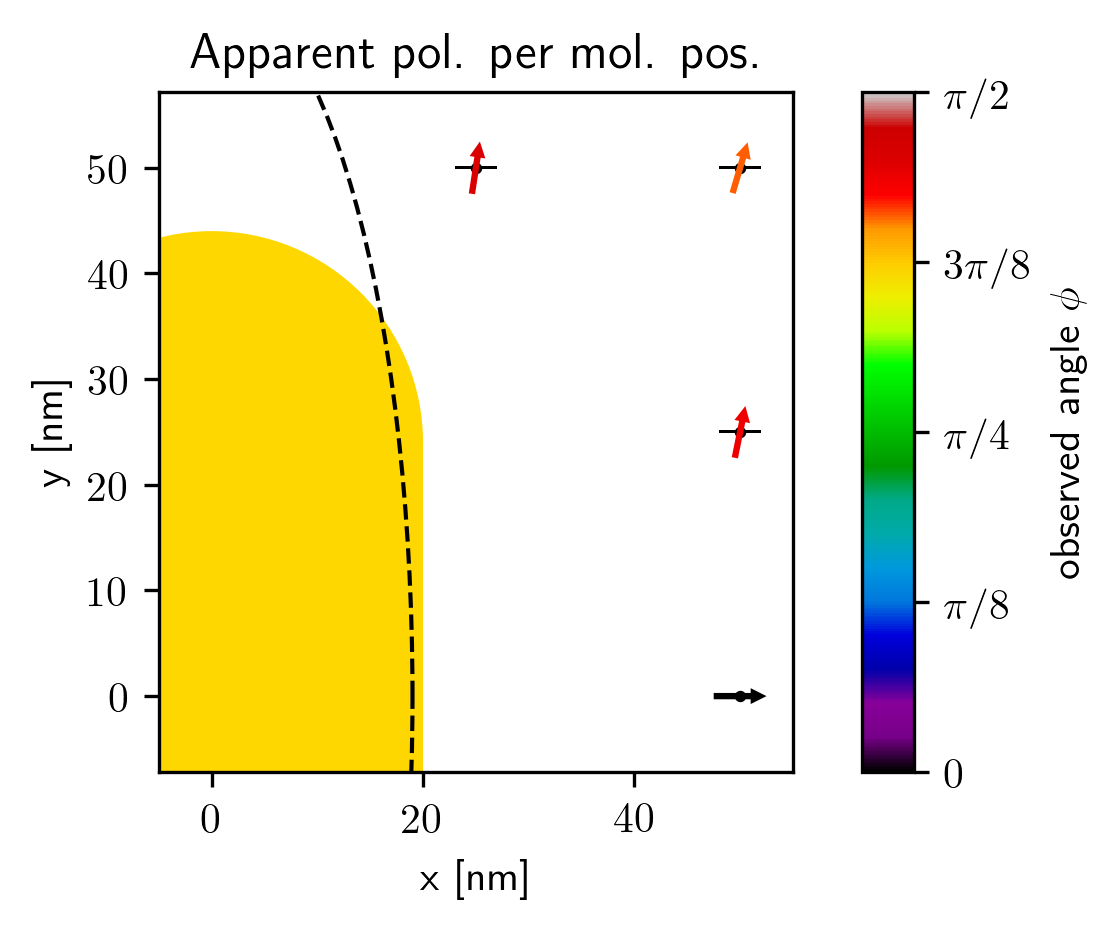

In [377]:
locations = diffi.observation_points(x_min=0, x_max=50, y_min=0, y_max=50, points=3)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

test_instance = MolCoupNanoRodExp(locations, plas_angle=np.pi/2)

test_instance.plot_mispol_map_wMisloc()

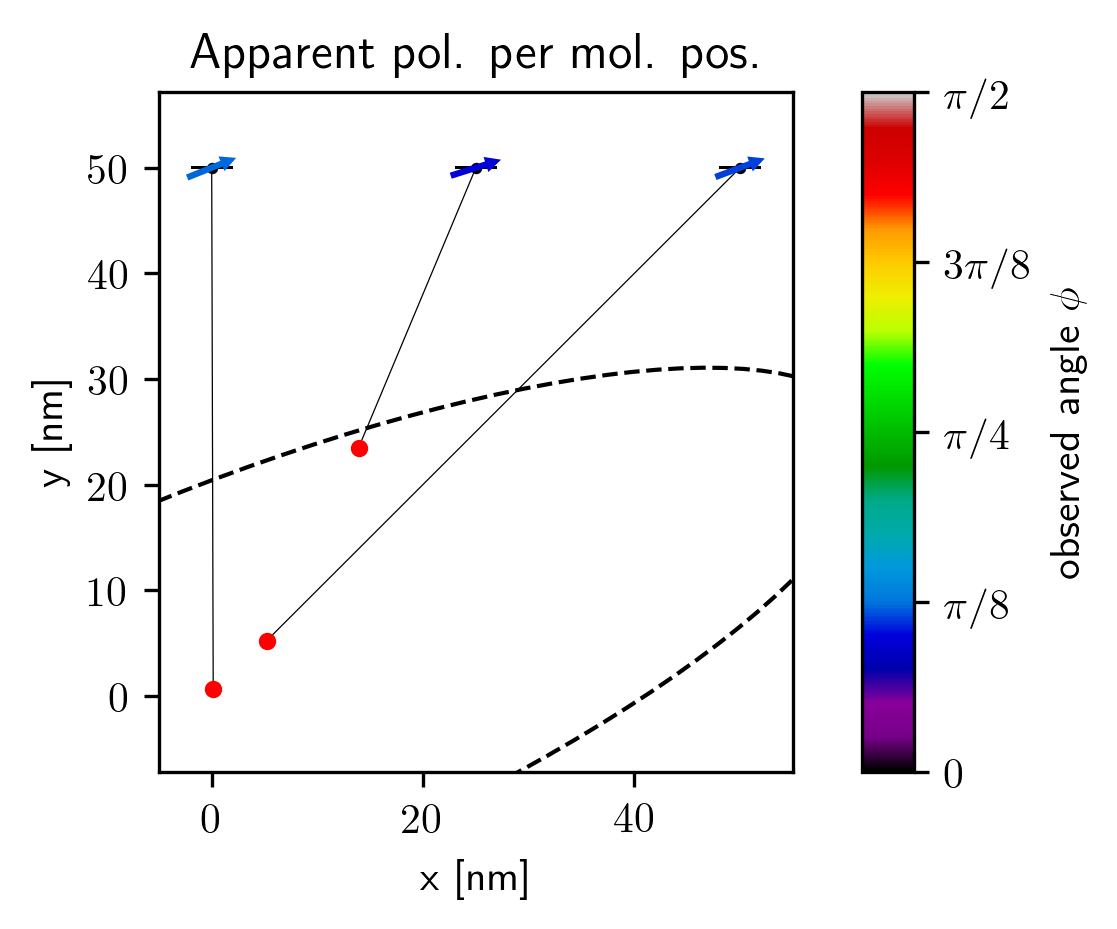

In [374]:
locations = diffi.observation_points(x_min=0, x_max=50, y_min=0, y_max=50, points=3)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

test_instance = MolCoupNanoRodExp(locations, plas_angle=np.pi/8)

test_instance.plot_mispol_map_wMisloc()

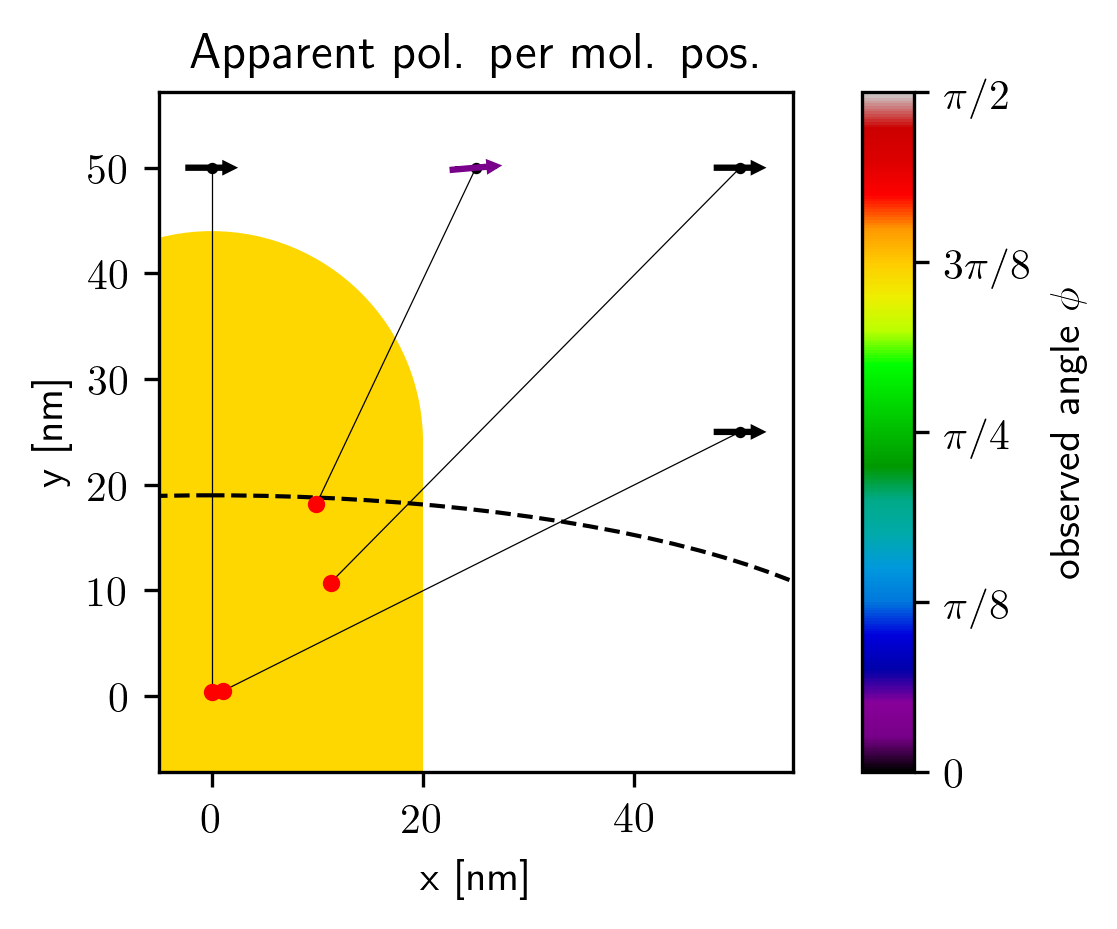

In [368]:
locations = diffi.observation_points(x_min=0, x_max=50, y_min=0, y_max=50, points=3)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

test_instance = MolCoupNanoRodExp(locations, plas_angle=np.pi)
test_instance.plot_mispol_map_wMisloc()

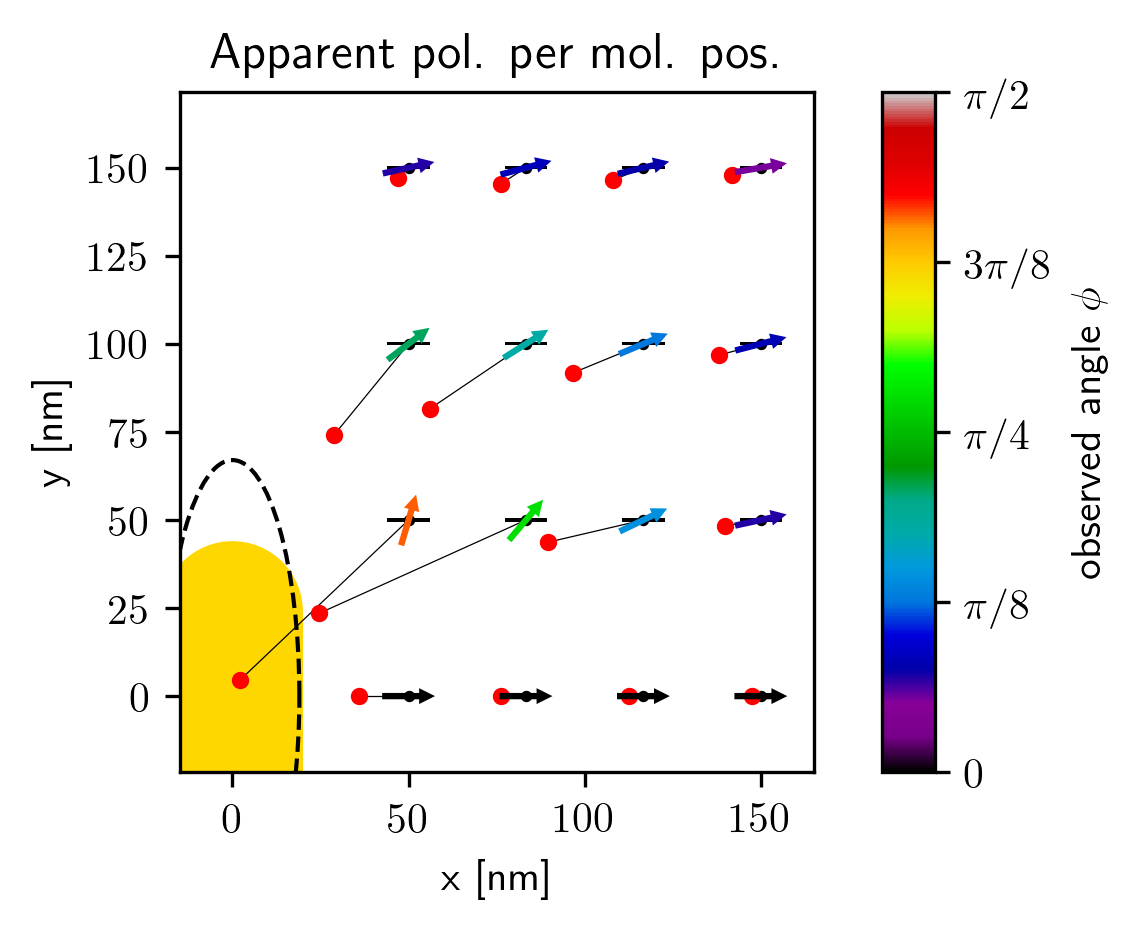

In [369]:
locations = diffi.observation_points(x_min=50, x_max=150, y_min=0, y_max=150, points=4)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
test_instance2 = MolCoupNanoRodExp(locations)
test_instance2.plot_mispol_map_wMisloc()

In [10]:
number_of_molecules = 1000

def random_ori_mol_placement(x_min=0, x_max=350, y_min=0, y_max=350, mol_grid_pts_1D = 10):
    locations = diffi.observation_points(x_min, x_max, y_min, y_max, points=mol_grid_pts_1D)[0]
    locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
    
    mol_linspace_pts = mol_grid_pts_1D
    random_mol_angles_0To360= (np.random.random(mol_linspace_pts**2)*np.pi*2)
    return [locations, random_mol_angles_0To360]

In [11]:
locations, angles = random_ori_mol_placement(x_min=0, x_max=500, y_min=0, y_max=500, mol_grid_pts_1D = 10)
test_instance3 = MolCoupNanoRodExp(locations, angles)

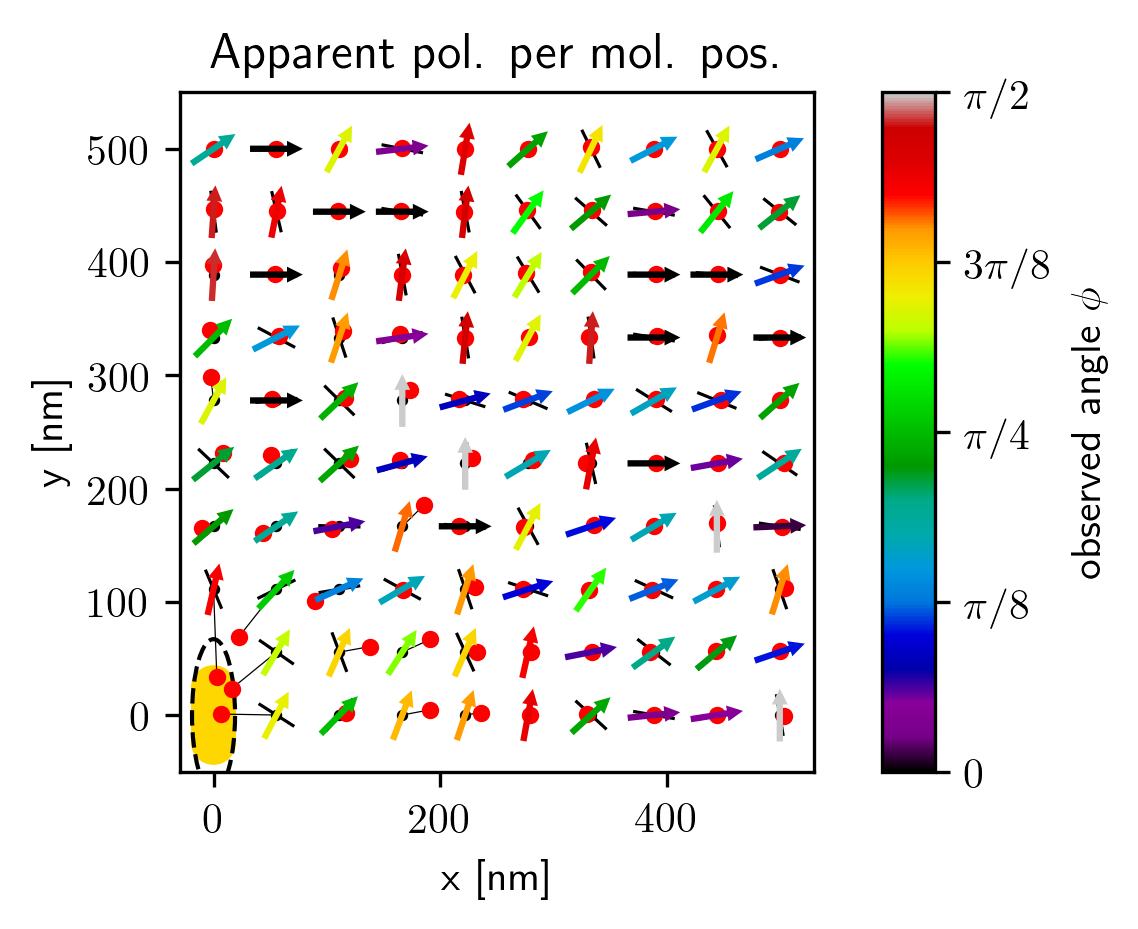

In [12]:
test_instance3.plot_mispol_map_wMisloc()

In [13]:
test_instance3.appar_cents.shape

(2, 98)

(-35.58211899024207, 530.1945506175626, -26.265969341673042, 539.5107002661316)

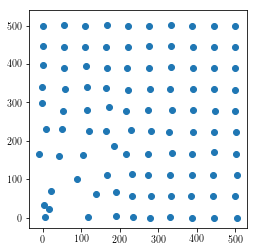

In [14]:
plt.scatter(*test_instance3.appar_cents)
plt.axis('square')
# plt.tight_layout()

In [17]:
locations4, angles4 = random_ori_mol_placement(x_min=0, x_max=350, y_min=0, y_max=350, mol_grid_pts_1D = 100)
test_instance4 = MolCoupNanoRodExp(locations4, angles4)

(-27.876231999260384,
 376.5338122575671,
 -21.02233985175011,
 383.38770440507733)

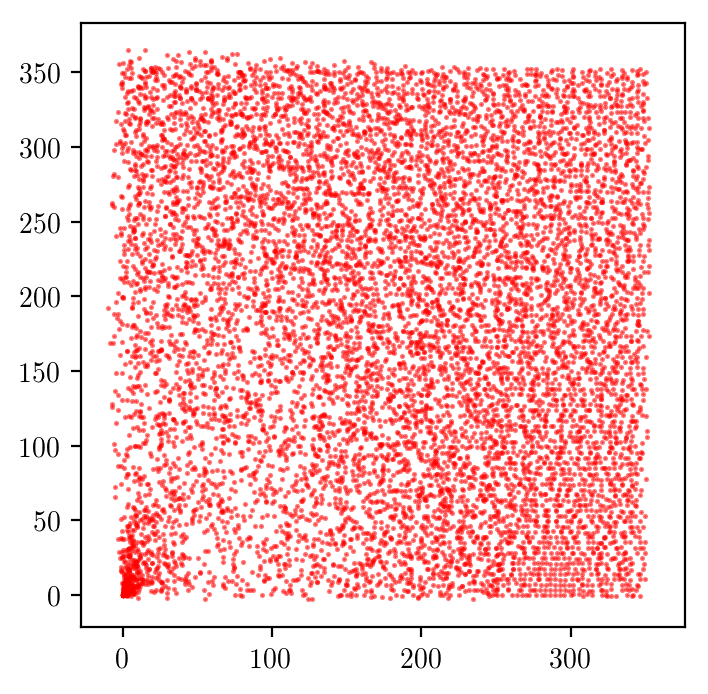

In [38]:
plt.figure(dpi=200)
plt.scatter(*test_instance4.appar_cents, alpha=.5, s=.75, c='Red')
plt.axis('square')

In [42]:
test_instance4.x_cen.shape

(9843,)

In [60]:
from scipy import stats
xmin = 0
xmax = 350
ymin = 0
ymax = 350
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([test_instance4.x_cen, test_instance4.y_cen])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

(-27.913510727003583,
 376.6113322609534,
 -21.079739217314955,
 383.44510377064205)

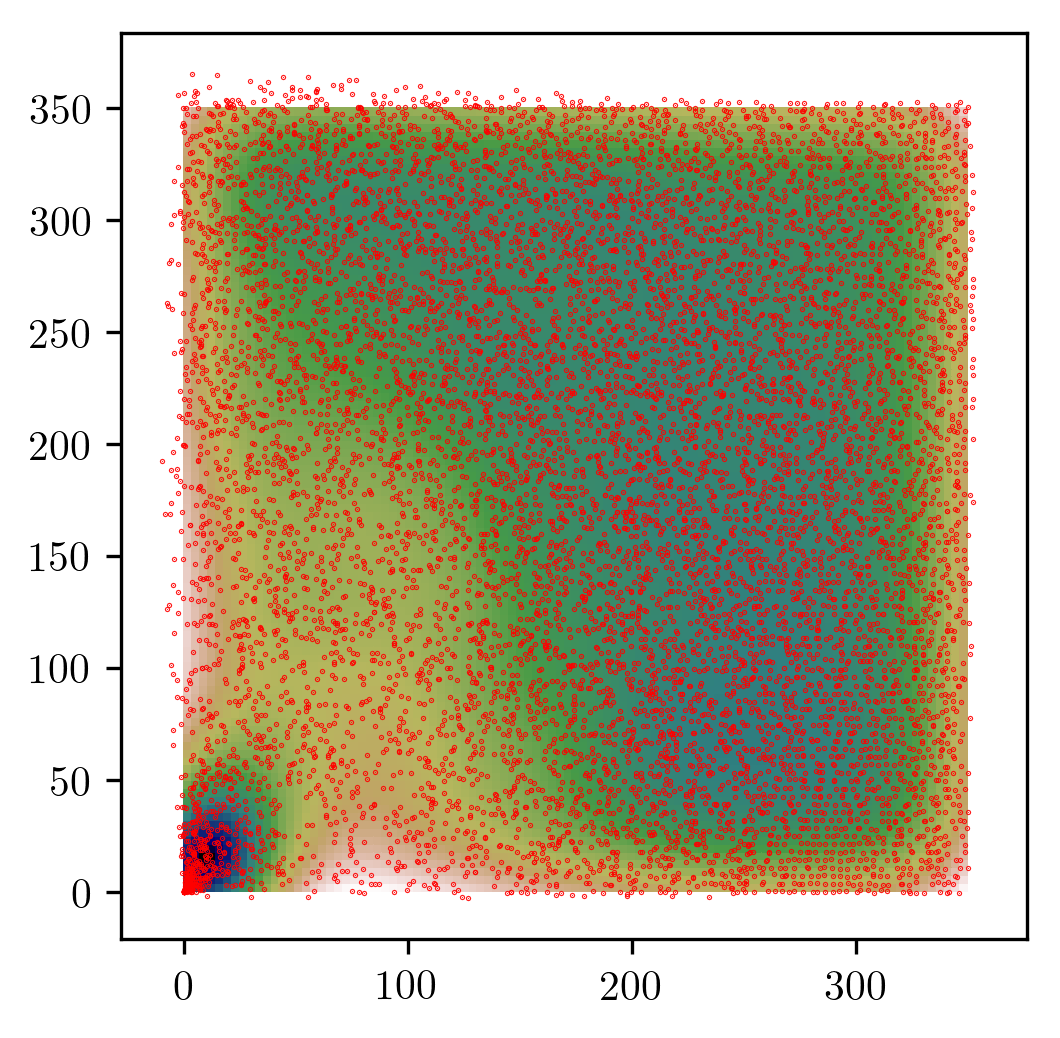

In [63]:
# fig, ax = plt.subplots()
# ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,)
fig2, ax2 = plt.subplots(dpi=300)
ax2.pcolor(X, Y, Z, cmap=plt.cm.gist_earth_r, )
ax2.scatter(*test_instance4.appar_cents, alpha=.9, s=.075, c='Red')
plt.axis('square')

In [100]:
xmin = -350
xmax = 350
ymin = -350
ymax = 350
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values_Q1 = np.vstack([test_instance4.x_cen, test_instance4.y_cen])
values_Q2 = values_Q1 * np.array([-1, 1])[:,None]
values_Q3 = values_Q1 * np.array([-1, -1])[:,None]
values_Q4 = values_Q1 * np.array([1, -1])[:,None]
values = np.hstack([values_Q1, values_Q2, values_Q3, values_Q4])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

(-350.0, 400.8660345102936, -350.0, 400.8660345102936)

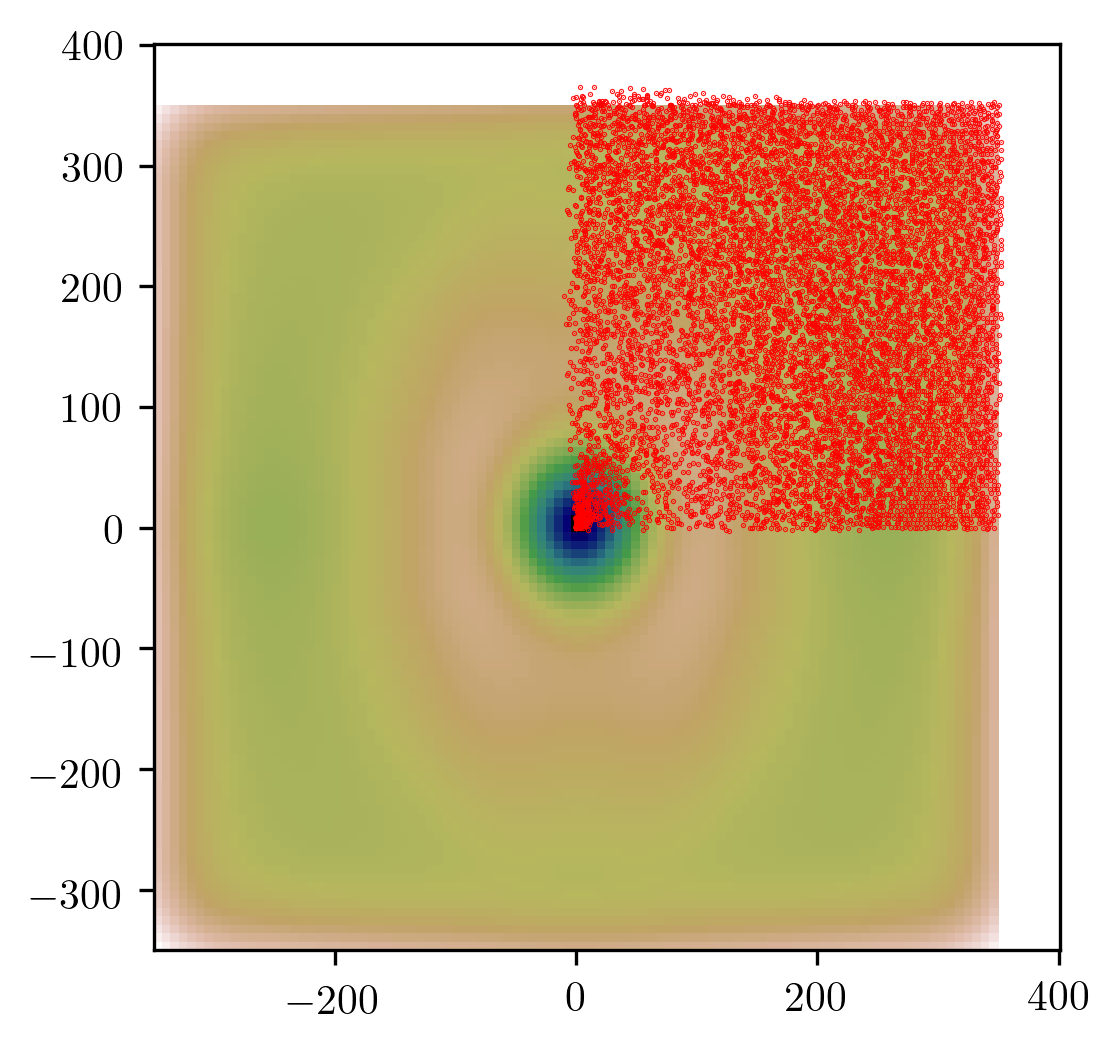

In [180]:
# fig, ax = plt.subplots()
# ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,)
fig4, ax4 = plt.subplots(dpi=300)
ax4.pcolor(X, Y, Z, cmap=plt.cm.gist_earth_r, )
ax4.scatter(*test_instance4.appar_cents, alpha=.9, s=.075, c='Red')
plt.axis('square')
# fig4.colorbar()

In [181]:
test_instance4.appar_cents.shape

(2, 9843)

## Coming in on 11/25/18 to save and sort data

In [184]:
import pickle

In [187]:
class Company(object):
    def __init__(self, name, value):
        self.name = name
        self.value = value

with open('company_data.pkl', 'wb') as output:
    company1 = Company('banana', 40)
    pickle.dump(company1, output, pickle.HIGHEST_PROTOCOL)

In [189]:
with open('pkl_test.pkl', 'wb') as output:
    pickle.dump(test_instance4, output, pickle.HIGHEST_PROTOCOL)

OSError: [Errno 22] Invalid argument

pickle is not working for some reason...

In [190]:
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size


def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

In [191]:
pickle_dump(test_instance4, 'pkl_fix_test.pkl')

writing total_bytes=205...
writing bytes [0, 205)... done.
writing total_bytes=236232...
writing bytes [0, 236232)... done.
writing total_bytes=56...
writing bytes [0, 56)... done.
writing total_bytes=78744...
writing bytes [0, 78744)... done.
writing total_bytes=118...
writing bytes [0, 118)... done.
writing total_bytes=80000...
writing bytes [0, 80000)... done.
writing total_bytes=57...
writing bytes [0, 57)... done.
writing total_bytes=80000...
writing bytes [0, 80000)... done.
writing total_bytes=10186...
writing bytes [0, 10186)... done.
writing total_bytes=4724640000...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 3221225472)... done.
writing bytes [3221225472, 4294967296)... done.
writing bytes [4294967296, 4724640000)... done.
writing total_bytes=61...
writing bytes [0, 61)... done.
writing total_bytes=4724640000...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing 

KeyboardInterrupt: 

looks like this fix is working but it takes just as long to calculate so I'm going to abort and just save centroid positions and angles. 

In [195]:
centroids_to_save = test_instance4.appar_cents.T
# test_instance4.appar_cents.shape

In [196]:
angles_to_save = test_instance4.angles

In [197]:
locations_to_save = test_instance4.mol_locations

In [199]:
x_powers_to_save = test_instance4.Px_per_drive_I
y_powers_to_save = test_instance4.Py_per_drive_I

In [204]:
array_to_save = np.hstack([locations_to_save,
                           centroids_to_save,
                           angles_to_save[:,None],
                           x_powers_to_save[:,None],
                           y_powers_to_save[:,None]
                          ])

In [205]:
np.savetxt('many_mols_out_to_350nm_first_quad.txt', array_to_save)

ok, lets sort this thing by angles

In [210]:
angle_sorted_indicies = np.argsort(test_instance4.angles)
sorted_angles = test_instance4.mispol_angle[angle_sorted_indicies]
sorted_centroids = test_instance4.appar_cents[:,angle_sorted_indicies]

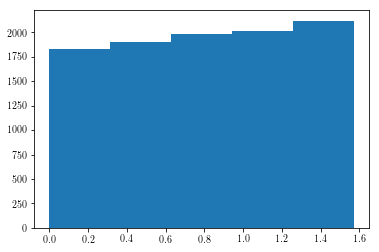

In [216]:
angle_histogram = plt.hist(sorted_angles,5)

In [218]:
dir(angle_histogram)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']

In [223]:
angle_histogram.count(1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [227]:
index_bin_width = round(len(sorted_angles)/5)

In [272]:
def scatter_plot_localizations(x_centroids, y_centroids, angles):
    fig, ax = plt.subplots(dpi=200)
    scatter_plot = ax.scatter(x_centroids, y_centroids, 
            alpha=1, s=.75, c=angles*180/np.pi)
    ax.axis('square')
    ax.set_xlabel('$x$ [nm]')
    ax.set_ylabel('$y$ [nm]')
    plt.colorbar(scatter_plot, label='observed angle from x-axis [deg]')
    

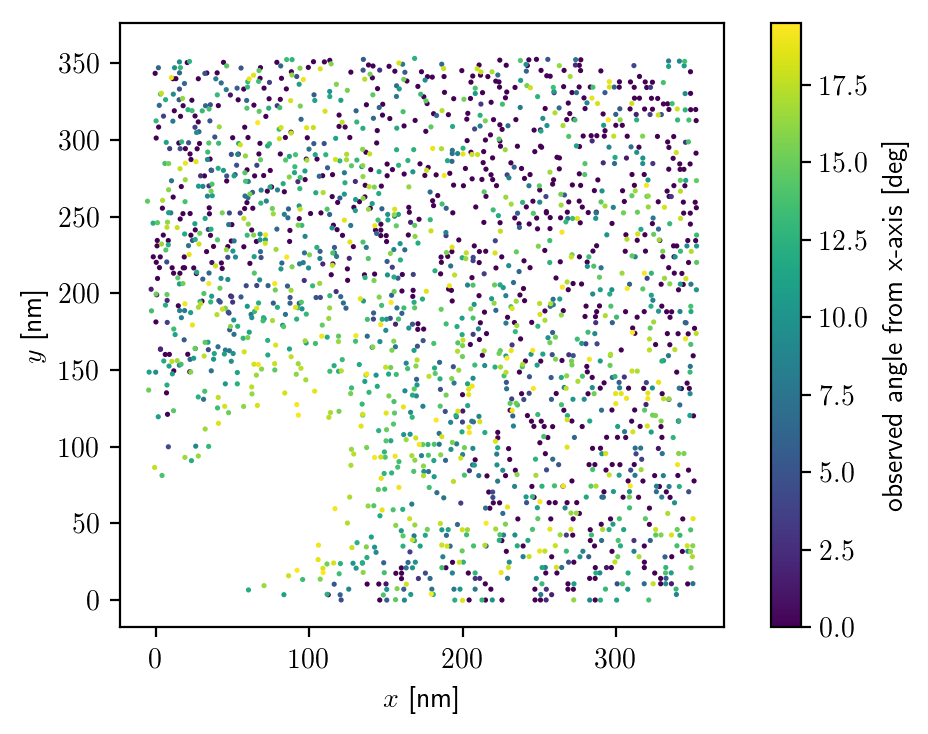

In [273]:
scatter_plot_localizations(*sorted_centroids[:,:index_bin_width],
                           sorted_angles[:index_bin_width])
# plt.scatter(*sorted_centroids[:,:index_bin_width], 
#             alpha=.5, s=.75, c=sorted_angles[:index_bin_width])
# plt.axis('square')

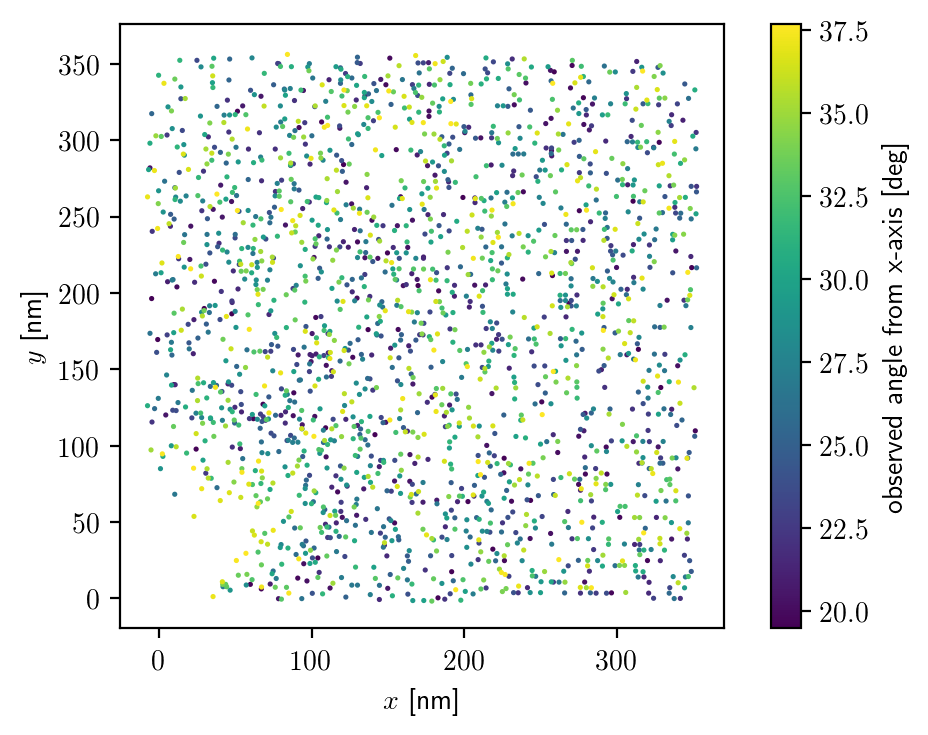

In [274]:
scatter_plot_localizations(*sorted_centroids[:, index_bin_width:2*index_bin_width],
                           sorted_angles[index_bin_width:2*index_bin_width])


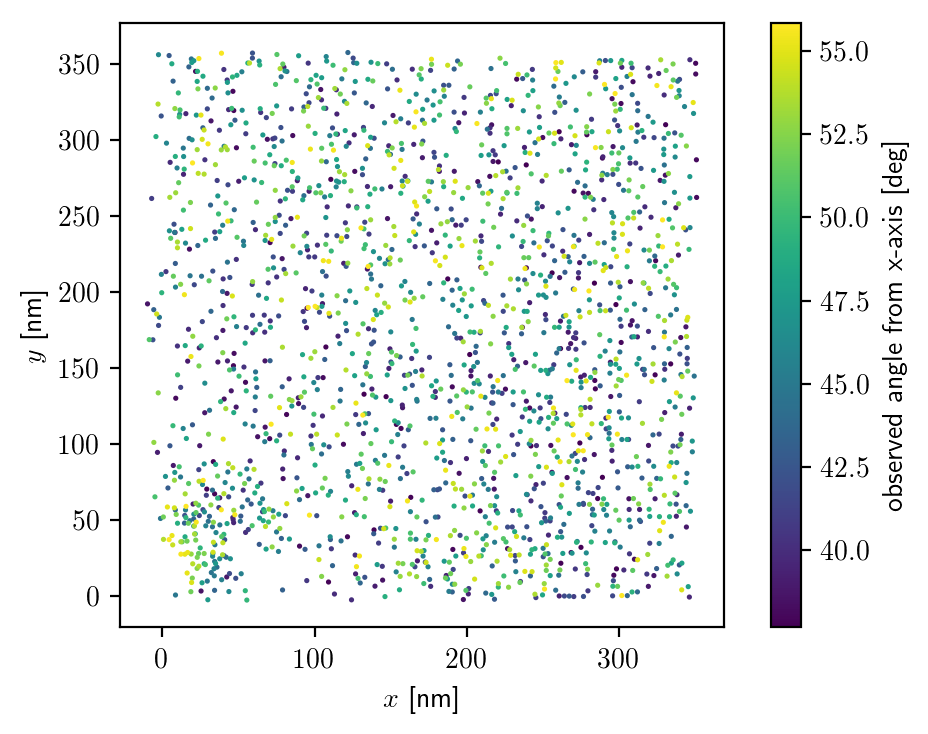

In [275]:
scatter_plot_localizations(*sorted_centroids[:, 2*index_bin_width:3*index_bin_width],
                           sorted_angles[2*index_bin_width:3*index_bin_width])


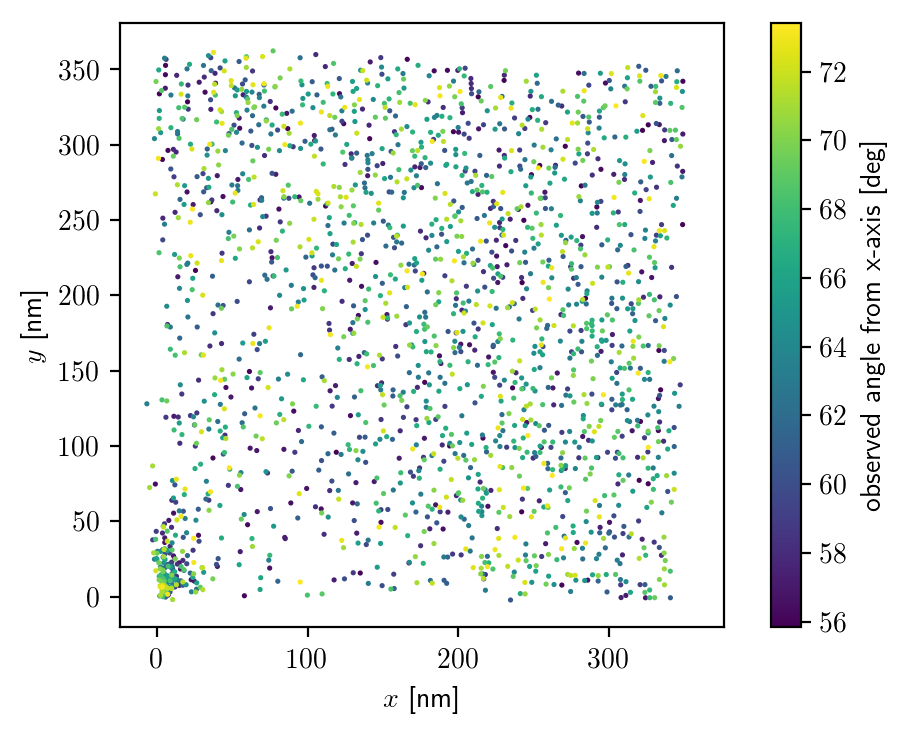

In [276]:
scatter_plot_localizations(*sorted_centroids[:, 3*index_bin_width:4*index_bin_width],
                           sorted_angles[3*index_bin_width:4*index_bin_width])


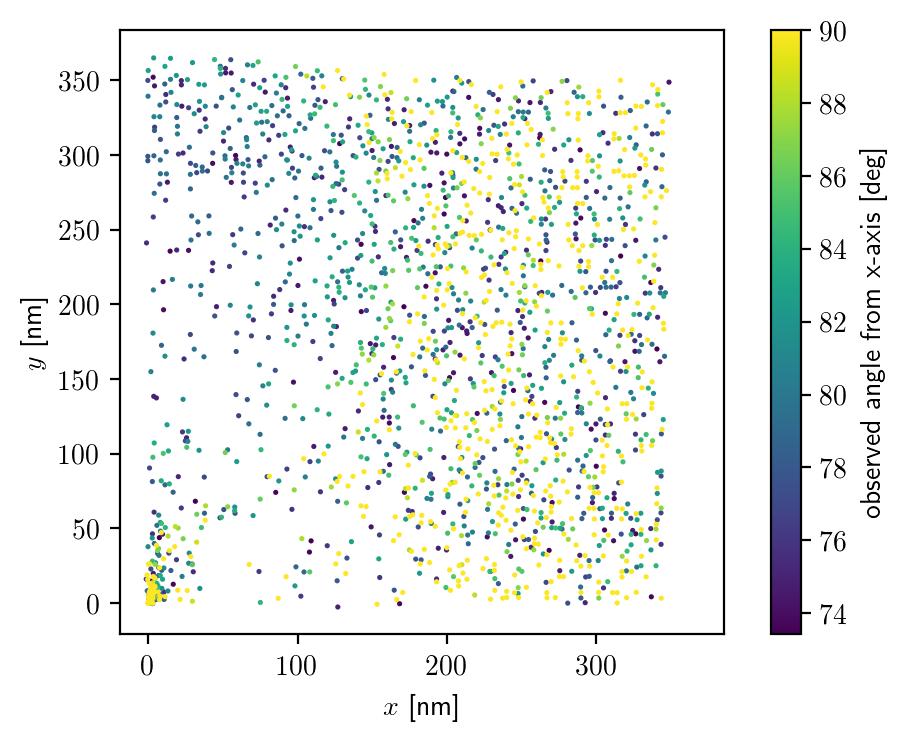

In [277]:
scatter_plot_localizations(*sorted_centroids[:, 4*index_bin_width:5*index_bin_width],
                           sorted_angles[4*index_bin_width:5*index_bin_width])


In [278]:
sorted_centroids.shape
# scatter_plot_localizations(*sorted_centroids[:, 4*index_bin_width:5*index_bin_width],
#                            sorted_angles[4*index_bin_width:5*index_bin_width])


(2, 9843)

In [279]:
stacked_sorted_centroids_and_angles = np.hstack([sorted_centroids.T, sorted_angles[:,None]])

In [281]:
stacked_sorted_centroids_and_angles.shape

(9843, 3)

by 10 degree increments as Curly has plotted

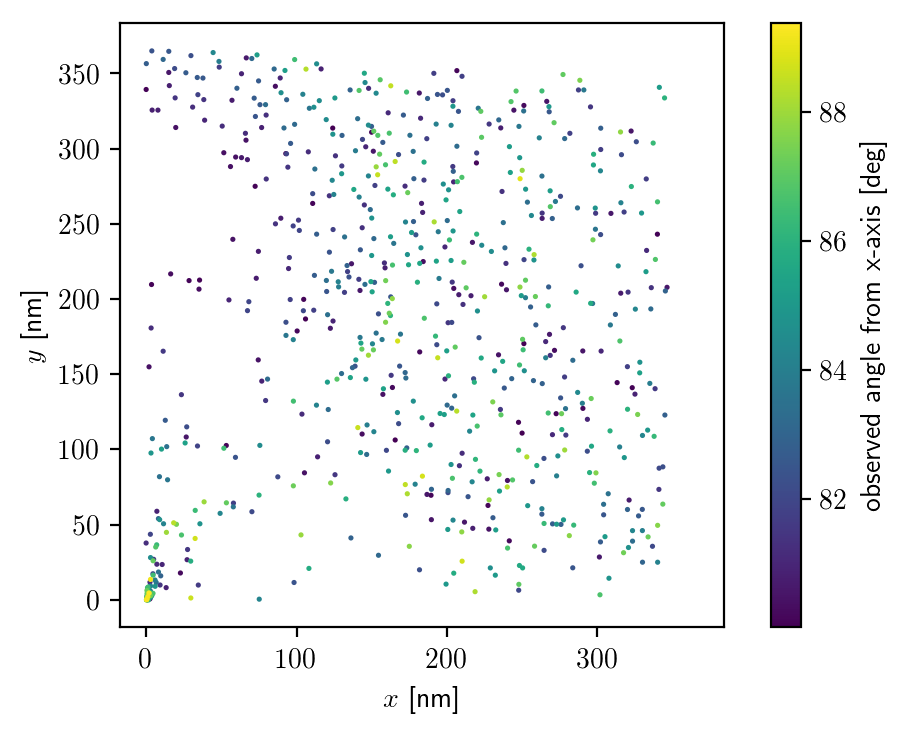

In [296]:
_max_angle = 90
_min_angle = 80
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

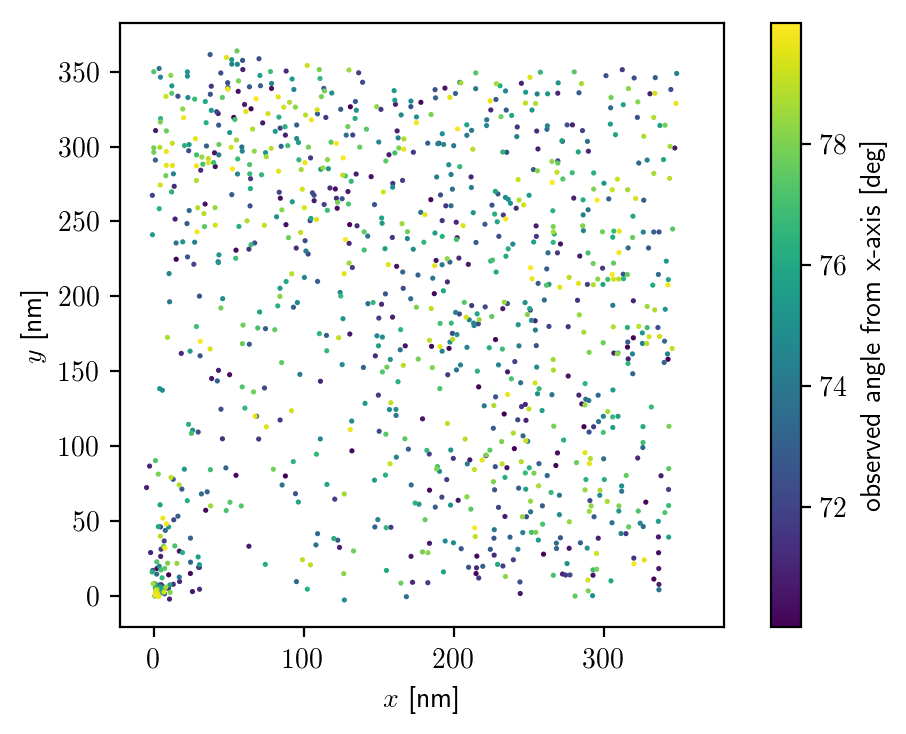

In [297]:
_max_angle = 80
_min_angle = 70
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

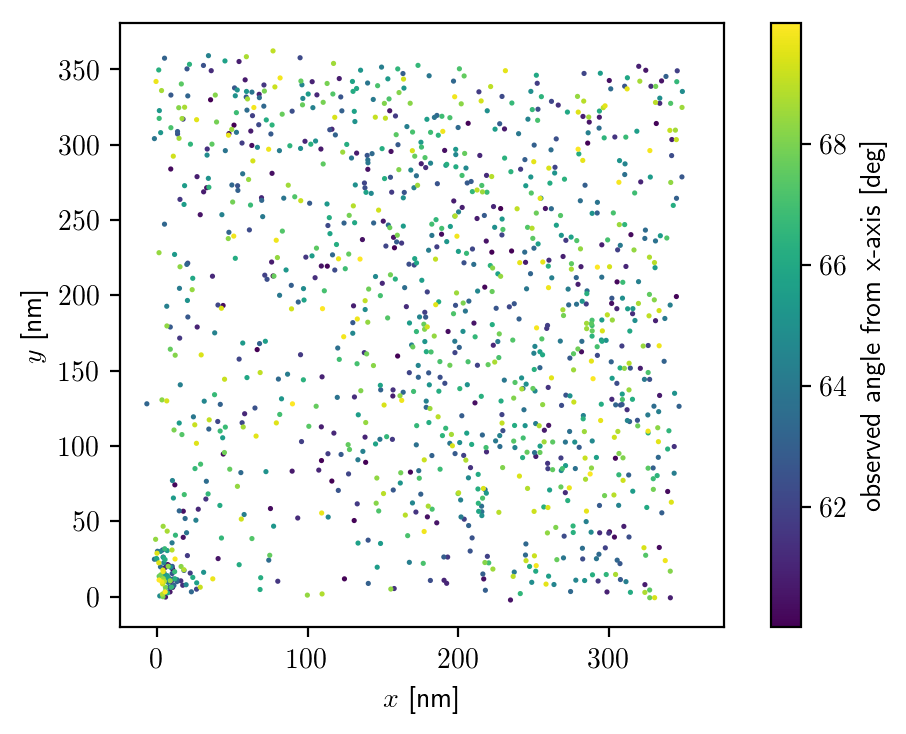

In [298]:
_max_angle = 70
_min_angle = 60
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

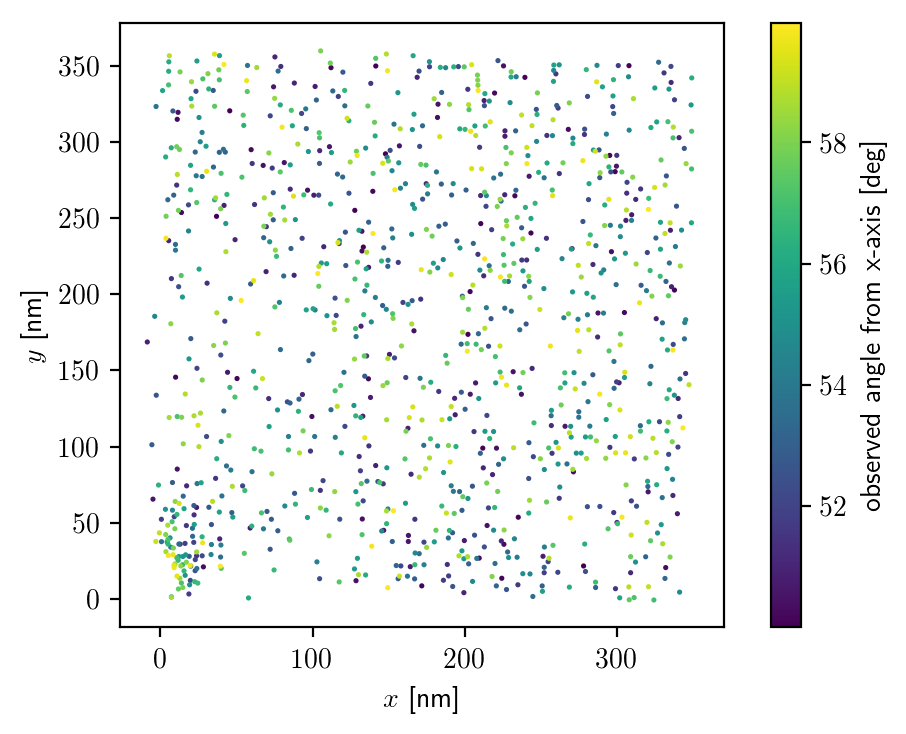

In [299]:
_max_angle = 60
_min_angle = 50
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

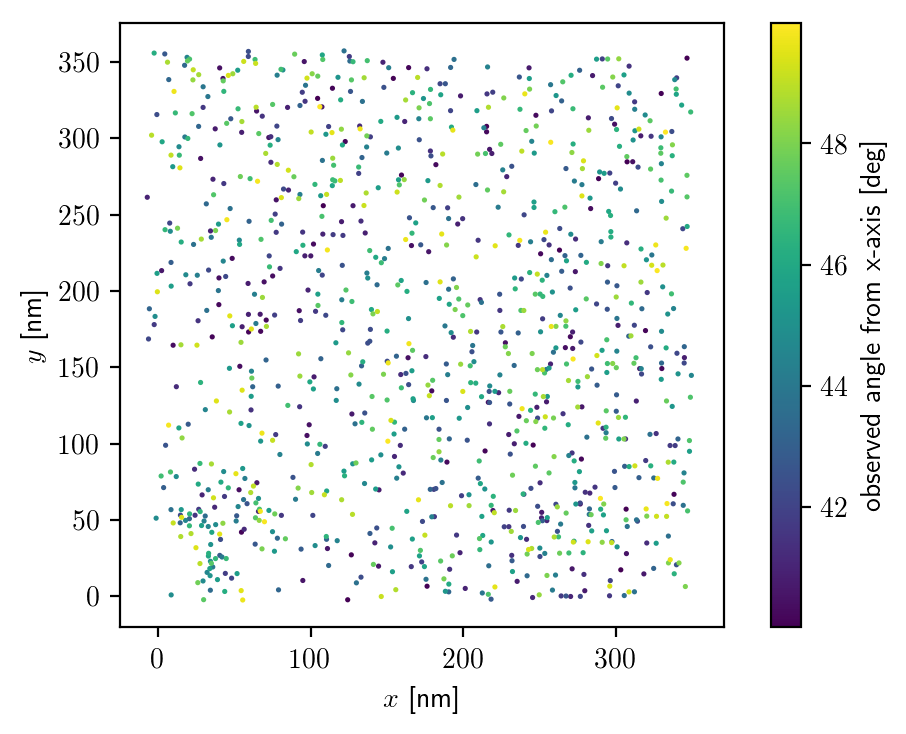

In [300]:
_max_angle = 50
_min_angle = 40
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

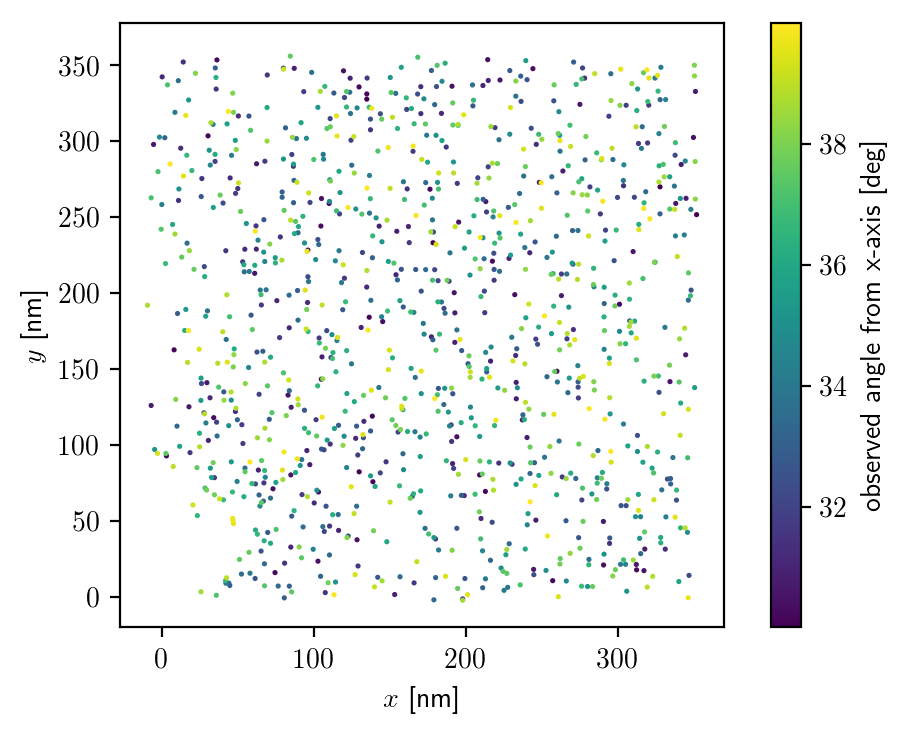

In [301]:
_max_angle = 40
_min_angle = 30
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

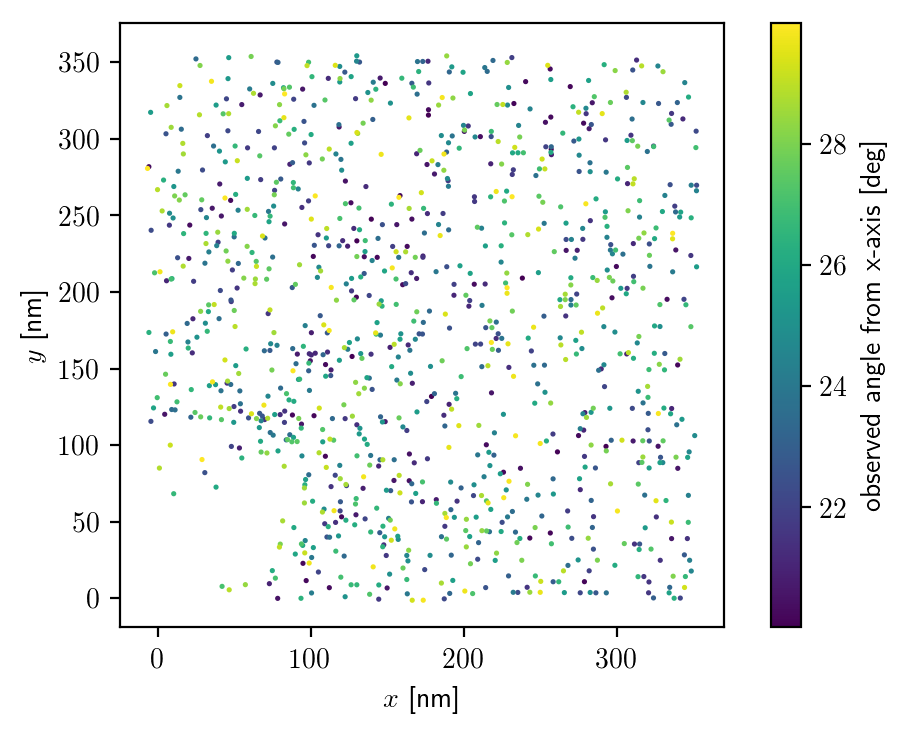

In [302]:
_max_angle = 30
_min_angle = 20
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

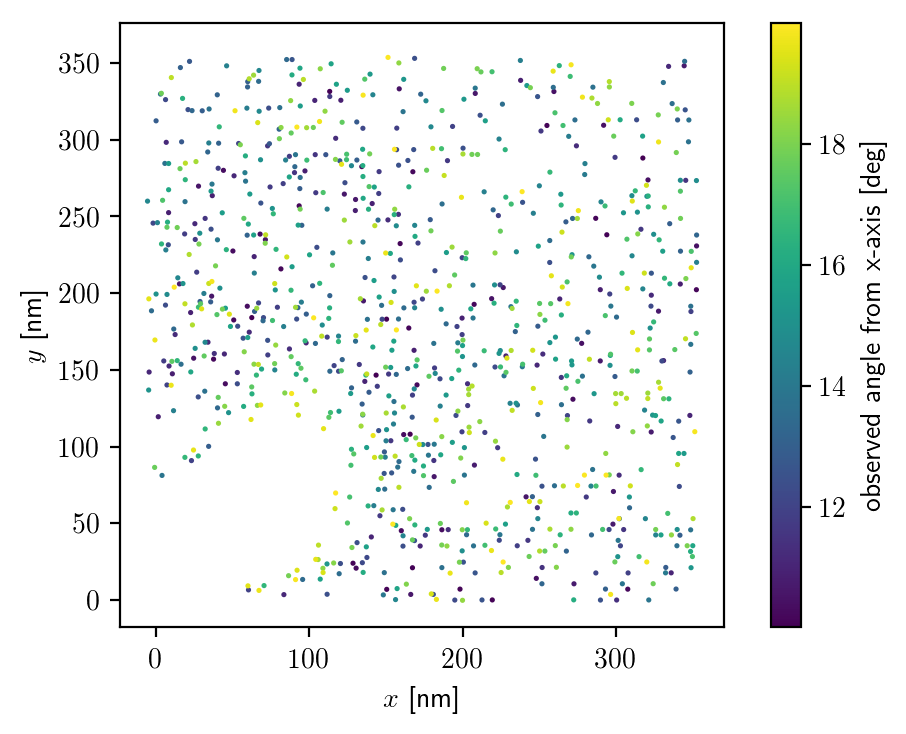

In [303]:
_max_angle = 20
_min_angle = 10
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

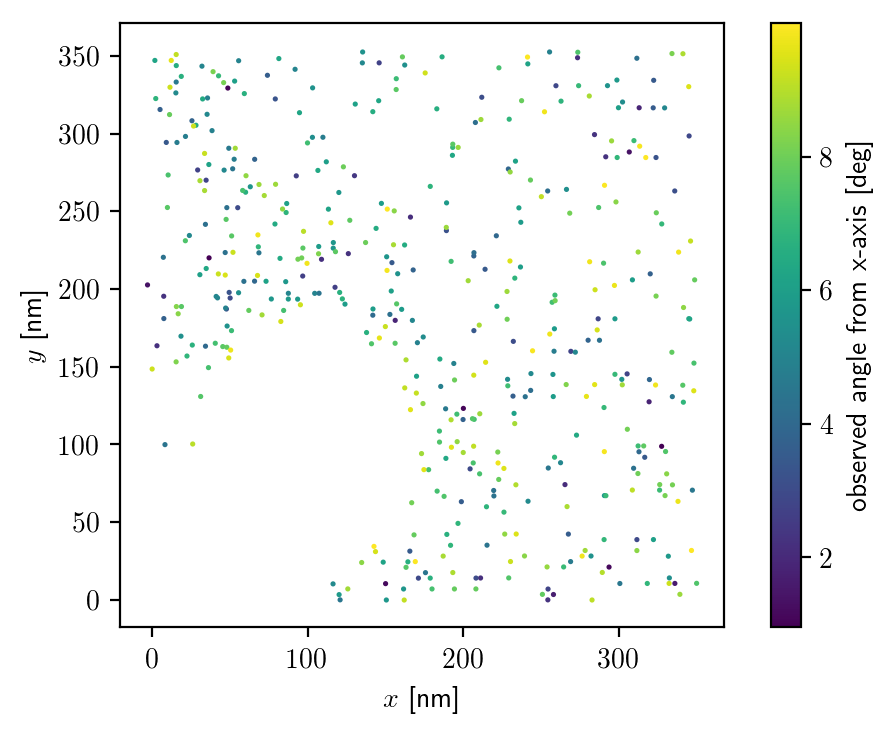

In [304]:
_max_angle = 10
_min_angle = 0
_x_centroids, _y_centroids, _angles = stacked_sorted_centroids_and_angles[
    np.logical_and(stacked_sorted_centroids_and_angles[:,2] < _max_angle*np.pi/180,
     stacked_sorted_centroids_and_angles[:,2] > _min_angle*np.pi/180)
    ].T

scatter_plot_localizations(_x_centroids, _y_centroids, _angles)

Realized I can just delete the fields and see if that is the memory hog

In [306]:
del test_instance4.mol_E

In [308]:
del test_instance4.plas_E

It was! we are now ok

## now time to try and rotate nanorod

In [316]:
locations6, angles6 = random_ori_mol_placement(x_min=-350, x_max=350, y_min=-350, y_max=350, mol_grid_pts_1D = 5)
test_instance6 = MolCoupNanoRodExp(locations6, angles6)
instance6 = MolCoupNanoRodExp(locations6, mol_angle=angles6, plas_angle=69*np.pi/2)

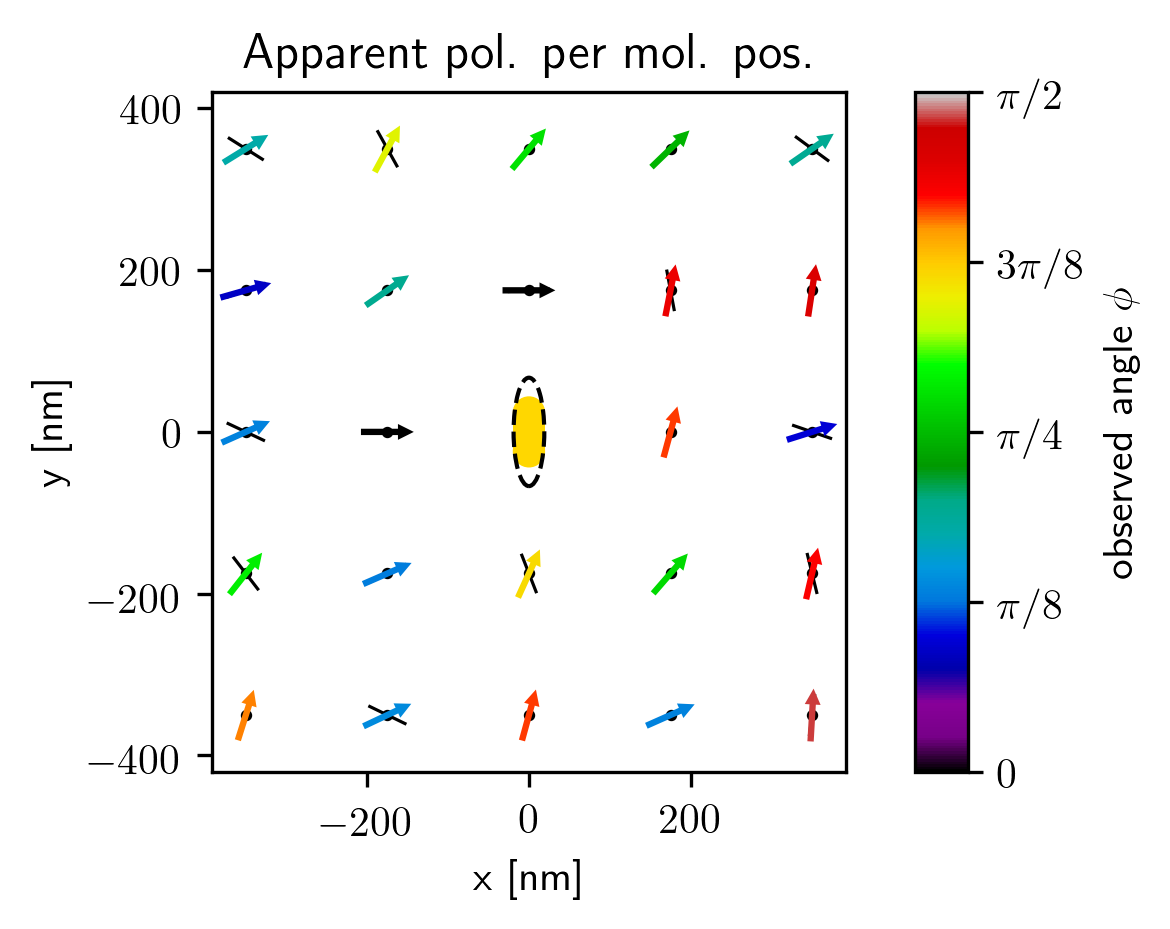

In [317]:
instance6.plot_mispol_map()